In [79]:
!pip install konlpy

In [80]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [81]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


('ratings_test.txt', <http.client.HTTPMessage at 0x7a904791b070>)

In [82]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
# txt의 경우 read_table로 바로 작업 가능
train_data=train_data[:1000]
test_data=test_data[:1000]

print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

train_data.head(20)

훈련용 리뷰 개수 : 1000
테스트용 리뷰 개수 : 1000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


##### 데이터 정제

In [83]:
len(train_data)

1000

In [84]:
# 중복 제거
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()
# return 값이 2개 이상인 것을 찾으면 됨

(1000, 2)

In [85]:
tmp=train_data['document'].value_counts()
tmp>1

아 더빙.. 진짜 짜증나네요 목소리                                                                                                                   False
무슨 내용인지 도통 모르겠다... 쓸데없이 특별해 보이려는 시도에만 열중이었던 영화.                                                                                       False
국민학교 다닐때 이거 동생이랑 보다가.... 눈물이...ㅋ                                                                                                      False
욕망이라는 이름의 전차.                                                                                                                         False
'디 워'랑 같은 부류.. 저예산 + 저렴한 CG + 마구잡이연출                                                                                                  False
                                                                                                                                      ...  
안습                                                                                                                                    False
감독의 의도를 전혀 알아차리지 못했다

In [86]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data['document'].value_counts() > 1

아 더빙.. 진짜 짜증나네요 목소리                                                                                                                   False
무슨 내용인지 도통 모르겠다... 쓸데없이 특별해 보이려는 시도에만 열중이었던 영화.                                                                                       False
국민학교 다닐때 이거 동생이랑 보다가.... 눈물이...ㅋ                                                                                                      False
욕망이라는 이름의 전차.                                                                                                                         False
'디 워'랑 같은 부류.. 저예산 + 저렴한 CG + 마구잡이연출                                                                                                  False
                                                                                                                                      ...  
안습                                                                                                                                    False
감독의 의도를 전혀 알아차리지 못했다

<Axes: >

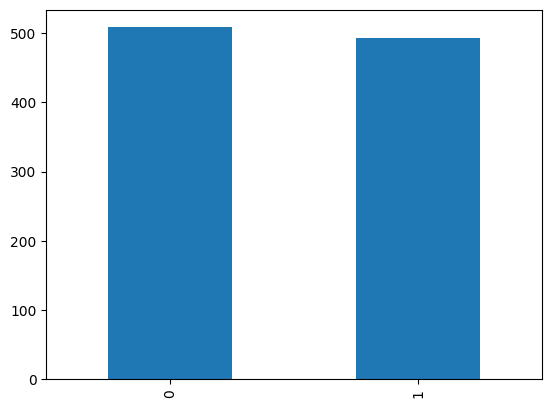

In [87]:
### y값 편향 유무 판단
train_data['label'].value_counts().plot(kind = 'bar')

In [88]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1000 non-null   int64 
 1   document  1000 non-null   object
 2   label     1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 31.2+ KB


In [89]:
# 결측치 확인 및 제거
train_data.loc[train_data.document.isnull()]

,id,document,label


In [90]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
train_data.info()

False
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1000 non-null   int64 
 1   document  1000 non-null   object
 2   label     1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 31.2+ KB


### 정규표현식 작업

In [91]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한국어의 경우 [^ㄱ-ㅎㅏ-ㅣ가-힣 ]와 같이 정규표현식을 지정해야함
train_data[:5]

<ipython-input-91-bf8b0bd379d8>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [92]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
# none 값 789

id          0
document    7
label       0
dtype: int64


<ipython-input-92-292cf5204d19>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [93]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

993


In [94]:
# 중복 제거
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))
# 작업 후 duplicate를 다시 봐야 함

전처리 후 테스트용 샘플의 개수 : 985


<ipython-input-94-39ac924addc3>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-94-39ac924addc3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


### 토큰화

In [95]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt=Okt()

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화, stem : 맞춤법 사전
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)


100%|██████████| 993/993 [00:05<00:00, 184.14it/s]


In [96]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)


100%|██████████| 985/985 [00:06<00:00, 144.15it/s]


### 정수 인코딩

In [97]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '있다': 5, '이다': 6, '좋다': 7, '다': 8, '적': 9, '진짜': 10, '정말': 11, '너무': 12, '아니다': 13, '재밌다': 14, '만': 15, '되다': 16, '같다': 17, '연기': 18, '인': 19, '로': 20, '나오다': 21, '점': 22, '최고': 23, '안': 24, '에서': 25, '사람': 26, '내': 27, '않다': 28, '보고': 29, '그': 30, '만들다': 31, '것': 32, '왜': 33, '못': 34, '하고': 35, '나': 36, '말': 37, '감동': 38, '재미': 39, '아깝다': 40, '고': 41, '재미없다': 42, '싶다': 43, 'ㅋㅋ': 44, '재미있다': 45, '생각': 46, '내용': 47, '배우': 48, '더': 49, '아': 50, '그냥': 51, '드라마': 52, '중': 53, '시간': 54, '평점': 55, '스토리': 56, '들다': 57, '감독': 58, '알다': 59, '때': 60, '쓰레기': 61, '게': 62, '그렇다': 63, '하나': 64, '작품': 65, '볼': 66, '자다': 67, '완전': 68, 'ㅠㅠ': 69, '모르다': 70, '주인공': 71, '개': 72, '기': 73, '요': 74, '지루하다': 75, '또': 76, '정도': 77, '주다': 78, '느낌': 79, '거': 80, '년': 81, '듯': 82, '오다': 83, 'ㅋㅋㅋ': 84, '네': 85, '돈': 86, '가다': 87, '지': 88, '수': 89, '다시': 90, '뭐': 91, '먹다': 92, '이건': 93, 'ㅡㅡ': 94, '이렇다': 95, '라': 96, '냐': 97, '마지막': 98, '안되다': 99, '난': 100, '인생': 101, '일': 102, '사

In [98]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 3272
등장 빈도가 2번 이하인 희귀 단어의 수: 2476
단어 집합에서 희귀 단어의 비율: 75.67237163814181
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 26.927302691814685


In [99]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 797


In [100]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [101]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])


### 빈 샘플 제거

In [102]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]


In [103]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))


977
977


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### 패딩

리뷰의 최대 길이 : 38
리뷰의 평균 길이 : 8.168884339815763


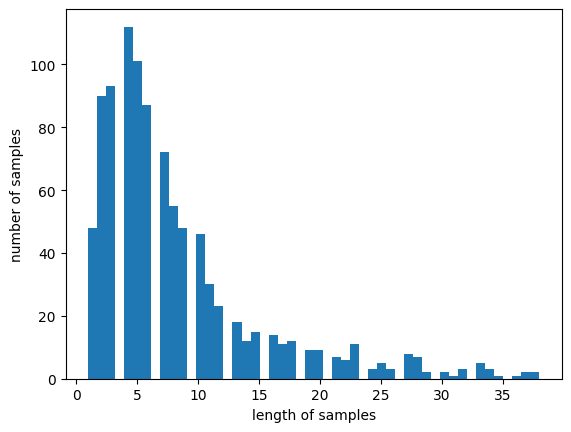

In [104]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [105]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [106]:
max_len = 30
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 30 이하인 샘플의 비율: 98.15762538382803


In [107]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


### LSTM 분류

In [108]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.6936 - acc: 0.4853
Epoch 1: val_acc improved from -inf to 0.49490, saving model to best_model.h5
13/13 [==============================] - 10s 209ms/step - loss: 0.6936 - acc: 0.4853 - val_loss: 0.6920 - val_acc: 0.4949
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.6889 - acc: 0.5391
Epoch 2: val_acc improved from 0.49490 to 0.62755, saving model to best_model.h5
13/13 [==============================] - 2s 136ms/step - loss: 0.6889 - acc: 0.5391 - val_loss: 0.6863 - val_acc: 0.6276
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.6780 - acc: 0.6786
Epoch 3: val_acc improved from 0.62755 to 0.64286, saving model to best_model.h5
13/13 [==============================] - 1s 101ms/step - loss: 0.6780 - acc: 0.6786 - val_loss: 0.6774 - val_acc: 0.6429
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.6395 - acc: 0.7055
Epoch 4: val_acc did not improve from 0.

In [109]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


31/31 [==============================] - 1s 4ms/step - loss: 0.5844 - acc: 0.6985

 테스트 정확도: 0.6985


In [110]:
# 토크나이저를 피클 단위로 저장하고 추후 불러들일 수 있음
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


### 리뷰 예측

In [111]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))


In [112]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')


1/1 [==============================] - 0s 364ms/step
72.14% 확률로 긍정 리뷰입니다.



In [113]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')


1/1 [==============================] - 0s 18ms/step
73.45% 확률로 긍정 리뷰입니다.

